# Movie Recommender Pipeline
**MALDASC Project - Alexander Sallmann**

## Setup: paths and helper function
**Download the MovieLens (ml-32m) dataset and place the content of the zip in the "data" folder**<br>
[Download MovieLens Dataset](https://files.grouplens.org/datasets/movielens/ml-32m.zip)

Set the paths (can differ depending on the project layout) and define helper to run the scripts.

In [2]:
from pathlib import Path
import sys
import subprocess

# Project root (current working directory)
ROOT = Path.cwd()
SCRIPTS = ROOT / "scripts"

ML_DIR = ROOT / "data" / "ml-32m"
INTERACTIONS = ROOT / "data" / "dataset" / "interactions.csv"
MOVIE_FEATURES = ROOT / "feature_store" / "movie_features.joblib"
MODEL_PATH = ROOT / "models" / "ridge_rating_model.joblib"

def run(cmd):
    """Run a command, show stdout + stderr, and raise a clear error if it fails."""
    print("$", " ".join(str(c) for c in cmd))
    result = subprocess.run(cmd, capture_output=True, text=True)

    if result.stdout:
        print("STDOUT:\n", result.stdout)
    if result.stderr:
        print("STDERR:\n", result.stderr)

    if result.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {result.returncode}")


## Step 1 – Build movie features (`build_movie_features.py`)

This script converts the raw MovieLens 32M data into a set of features
suitable for ML.

**Text features** (TF–IDF):
- genres from `movies.csv` (e.g. `Action|Comedy|Sci-Fi`)
- user-contributed tags from `tags.csv` (e.g. “time travel”, “mind-bending”)

**Numeric features**:
From the ratings:
- `global_mean_rating` – average MovieLens rating per movie  
- `log1p_rating_count` – `log(1 + n_ratings)` (popularity, but compressed)  

From the movie title:
- `year_norm` – normalized release year extracted from the title
  (e.g. `2010.0` from `"Inception (2010)"`), scaled to roughly [0, 1].

**Inputs**:
- `--ml-dir`: path to the MovieLens 32M directory (with `movies.csv`, `ratings.csv`, `tags.csv`, `links.csv`).
- `--max-features`: max TF–IDF vocabulary size.
- `--min-df`: minimum document frequency for TF–IDF terms.
- `--out`: output `.joblib` file containing movies, features and metadata.

In [3]:
MAX_FEATURES = 2000 # maximum number of features
MIN_DF = 20 # minimum document frequency

MOVIE_FEATURES.parent.mkdir(parents=True, exist_ok=True)
run([
    sys.executable,
    str(SCRIPTS / "build_movie_features.py"),
    "--ml-dir", str(ML_DIR),
    "--max-features", str(MAX_FEATURES),
    "--min-df", str(MIN_DF),
    "--out", str(MOVIE_FEATURES),
])

$ c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\venv\Scripts\python.exe c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\scripts\build_movie_features.py --ml-dir c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\ml-32m --max-features 2000 --min-df 20 --out c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\feature_store\movie_features.joblib
STDOUT:
 Loading MovieLens from c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\ml-32m ...
Loaded 87,585 movies, 32,000,204 ratings, 2,000,072 tags.
Building numeric features...
Building text corpus (genres + tags) and TF-IDF features...
Saved c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\feature_store\movie_features.joblib (87585 movies x 2000 text-features, 3 numeric features)



## Step 2 – Build interactions (`movielens_to_interactions.py`)

This script links MovieLens ratings in `ratings.csv` to the movies in `movies.csv`.
It produces a table of **interactions** with columns:

- `userId`
- `movie_rowid`
- `rating` (1–5)
- `timestamp`
- `title`

**Inputs**:
- `--ml-dir`: MovieLens directory (with `ratings.csv`, `links.csv`).
- `--min-user-ratings`: drop users with fewer ratings than this.
- `--min-movie-ratings`: drop movies with fewer ratings than this.
- `--out`: output `.csv` file.

Use the `min-*` parameters to filter out very sparse users or movies.

In [4]:
MIN_USER_RATINGS = 5
MIN_MOVIE_RATINGS = 5

INTERACTIONS.parent.mkdir(parents=True, exist_ok=True)
run([
    sys.executable,
    str(SCRIPTS / "movielens_to_interactions.py"),
    "--ml-dir", str(ML_DIR),
    "--min-user-ratings", str(MIN_USER_RATINGS),
    "--min-movie-ratings", str(MIN_MOVIE_RATINGS),
    "--out", str(INTERACTIONS),
])

$ c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\venv\Scripts\python.exe c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\scripts\movielens_to_interactions.py --ml-dir c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\ml-32m --min-user-ratings 5 --min-movie-ratings 5 --out c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\dataset\interactions.csv
STDOUT:
 Wrote 31,921,467 interactions for 200,948 users and 43,884 movies => c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\dataset\interactions.csv



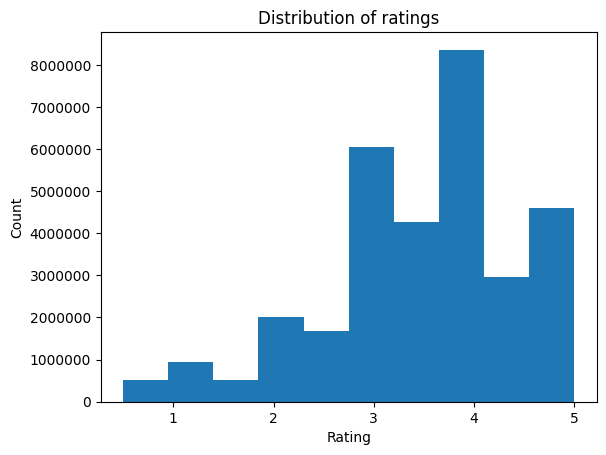

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

interactions = pd.read_csv(INTERACTIONS)

fig, ax = plt.subplots()

ax.hist(interactions['rating'], bins=10)
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title("Distribution of ratings")

ax.ticklabel_format(style='plain', axis='y')

plt.show()

## Step 3 – Train rating prediction model (`train_model.py`)

This script trains a **Ridge regression** model that predicts a user’s rating (1.0–5.0, float)
from:

- movie TF–IDF features (genres + tags),
- movie numeric features:
  - `global_mean_rating`
  - `log1p_rating_count`
  - `year_norm`
- user-level bias: the user’s mean rating (`user_mean_rating`),
- user–movie similarity: cosine similarity between the user’s profile vector
  in TF–IDF space and the movie’s TF–IDF vector (scaled by 10).

**Inputs**:
- `--interactions`: interactions file from Step 2.
- `--features`: movie features from Step 1.
- `--model-out`: where to save the trained model.
- `--test-size`: fraction of data used as test set.
- `--alpha`: Ridge regularization strength.
- `--max-samples`: max number of interactions to use
  (set to `-1` to use all interactions; we use a subset for faster training).

At the end, the script prints MAE and RMSE on a held-out test set and saves
`ridge_rating_model.joblib`, which contains the trained model and metadata.

In [34]:
TEST_SIZE = 0.2
ALPHA = 1.0
MAX_SAMPLES = 200_000

MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
run([
    sys.executable,
    str(SCRIPTS / "train_model.py"),
    "--interactions", str(INTERACTIONS),
    "--features", str(MOVIE_FEATURES),
    "--model-out", str(MODEL_PATH),
    "--test-size", str(TEST_SIZE),
    "--alpha", str(ALPHA),
    "--max-samples", str(MAX_SAMPLES),
])

$ c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\venv\Scripts\python.exe c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\scripts\train_model.py --interactions c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\dataset\interactions.csv --features c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\feature_store\movie_features.joblib --model-out c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\models\ridge_rating_model.joblib --test-size 0.2 --alpha 1.0 --max-samples 200000
STDOUT:
 Loading interactions from c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\data\dataset\interactions.csv ...
Total interactions: 31,921,467
Subsampling to 200,000 interactions (from 31,921,467) ...
Using 200,000 interactions.
Loading movie features from c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\feature_store\movie_features.joblib ...


## Step 4 – Inspect model coefficients (`explain_model.py`)

The script inspect which features push ratings **up** or **down**.
The script:

- reconstructs the full feature name list,
- prints the **top positive** and **top negative** coefficients.


In [27]:
run([
    sys.executable,
    str(SCRIPTS / "explain_model.py"),
    "--model", str(MODEL_PATH),
    "--features", str(MOVIE_FEATURES),
])

$ c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\venv\Scripts\python.exe c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\scripts\explain_model.py --model c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\models\ridge_rating_model.joblib --features c:\HSLU\MALDASC (Machine Learning and Data Science)\MovieRatingPredictor\feature_store\movie_features.joblib
STDOUT:
 
=== Top Positive Features (push rating higher) ===
+0.9598   user_mean_rating
+0.7773   genre:production
+0.7567   genre:axe
+0.7090   genre:prayer
+0.6782   genre:revolver
+0.6605   genre:sunglasses
+0.5999   genre:psycho
+0.5988   genre:bare
+0.5645   genre:frame
+0.5636   genre:knocked
+0.5598   genre:decapitation
+0.5251   genre:kissing
+0.5223   genre:threat
+0.5188   genre:timeline
+0.5160   genre:murders

=== Top Negative Features (push rating lower) ===
-0.7306   genre:screenplay
-0.7238   genre:simple
-0.6704   genre:company
-0.5905   genre:bat

# Step 5 - Recommend movie for new user

Executing without the "run" command (because we need user input for this step)

In [37]:
from pathlib import Path
import importlib
from turtle import title

import ipywidgets as widgets
from IPython.display import display, HTML

import scripts.recommend_for_new_user as r4u

importlib.reload(r4u)


def run_notebook_ui(
    model_path: Path,
    features_path: Path,
    profiles_dir: Path,
    profile_name: str | None = None,
    num_candidates: int = 30,
    min_ratings: int = 20,
    num_recs: int = 10,
):
    """
    Jupyter UI:
      - load/select profile
      - Phase 1: rate diverse popular movies
      - Phase 2: rate personalized recommendations (with predicted rating)
      - then compute final recommendations and save profile
    """
    # 1) Load model + features
    print("Loading model and movie features...")
    model, movies, X_tfidf, num, tfidf = r4u.load_model_and_features(model_path, features_path)
    print(f"Loaded {len(movies)} movies.\n")

    # 2) Choose / load profile (still CLI-style)
    profile_name, user_ratings, profile_path = r4u.choose_profile(
        profiles_dir=profiles_dir,
        profile_name_arg=profile_name,
    )
    print(f"Current profile '{profile_name}' has {len(user_ratings)} ratings/preferences.\n")

    # 3) Candidate pool for phase 1
    rating_pool = r4u.select_candidate_movies(
        movies,
        X_tfidf,
        per_genre=5,
        top_genres=8,
        extra_random=20,
        min_year=1990,
    )

    if user_ratings:
        already = set(user_ratings.keys())
        rating_pool = rating_pool[~rating_pool["movie_rowid"].isin(already)]

    rating_pool = rating_pool.head(num_candidates).reset_index(drop=True)

    if rating_pool.empty:
        print("No candidate movies available to rate.")
        return

    # placeholders for phase 2
    rec_pool = None  # will be set after phase 1

    # 4) Widgets
    output = widgets.Output()

    # star buttons
    btn_1 = widgets.Button(description="1 ⭐", tooltip="1 - hated it")
    btn_2 = widgets.Button(description="2 ⭐", tooltip="2 - not good")
    btn_3 = widgets.Button(description="3 ⭐", tooltip="3 - okay")
    btn_4 = widgets.Button(description="4 ⭐", tooltip="4 - liked it")
    btn_5 = widgets.Button(description="5 ⭐", tooltip="5 - loved it")

    # slider for decimal ratings
    rating_slider = widgets.FloatSlider(
        value=4.0,
        min=1.0,
        max=5.0,
        step=0.1,
        description="Rating",
        readout_format=".1f",
        continuous_update=False,
    )
    btn_slider_apply = widgets.Button(description="Use slider rating")

    # control buttons
    btn_skip = widgets.Button(description="Skip", button_style="warning")
    btn_done = widgets.Button(description="Next phase / Finish", button_style="success")

    buttons_row_1 = widgets.HBox([btn_1, btn_2, btn_3, btn_4, btn_5])
    buttons_row_2 = widgets.HBox([btn_skip, btn_done])
    slider_row = widgets.HBox([rating_slider, btn_slider_apply])

    ui_box = widgets.VBox([output, slider_row, buttons_row_1, buttons_row_2])

    # 5) state
    state = {
        "phase": "rating",
        "rating_i": 0,
        "recs_i": 0,
        "last_render": None,
    }

    def get_tmdb_details(row):
        tmdb_id = row.get("tmdb_id")
        if "tmdb_id" not in row or tmdb_id != tmdb_id:
            return None
        try:
            return r4u.fetch_tmdb_details(int(tmdb_id))
        except Exception:
            return None

    def current_pool_and_index():
        if state["phase"] == "rating":
            return rating_pool, state["rating_i"]
        elif state["phase"] == "recs":
            return rec_pool, state["recs_i"]
        else:
            return None, None

    def render_current_movie():
        pool, i = current_pool_and_index()

        current_key = (state["phase"], i)
        if state.get("last_render") == current_key:
            return
        state["last_render"] = current_key

        with output:
            output.clear_output(wait=True)

            if pool is None:
                print("No movies to show.")
                return

            if i is None or i >= len(pool):
                if state["phase"] == "rating":
                    print("No more movies to rate in Phase 1. You can click 'Next phase / Finish'.")
                elif state["phase"] == "recs":
                    print("No more recommended movies to rate. Click 'Next phase / Finish' to see final recommendations.")
                return

            row = pool.iloc[i]
            movie_id = int(row["movie_rowid"])
            base_title = str(row.get("title", "Unknown title"))

            details = get_tmdb_details(row)
            display_title = base_title
            overview = ""
            year = None
            poster_url = None

            if details is not None:
                if details.get("title"):
                    display_title = details["title"]
                overview = details.get("overview") or ""
                rd = details.get("release_date") or ""
                if len(rd) >= 4:
                    year = rd[:4]
                poster_path = details.get("poster_path")
                if poster_path:
                    poster_url = f"https://image.tmdb.org/t/p/w342{poster_path}"

            # Header
            phase_label = "Phase 1: rate popular movies" if state["phase"] == "rating" else "Phase 2: refine on recommendations"
            print(f"{phase_label}")
            print(f"[{i+1}/{len(pool)}]  movie_rowid={movie_id}")
            print(f"Title: {display_title}")
            if year:
                print(f"Year : {year}")

            # If in recs phase, show predicted rating
            if state["phase"] == "recs" and "pred_rating" in row:
                print(f"Predicted rating: {min(max(row['pred_rating'], 1.0), 5.0):.2f}")

            # Poster + overview
            html_parts = []
            if poster_url:
                html_parts.append(
                    f'<img src="{poster_url}" '
                    f'style="max-height:300px;margin-right:15px;border-radius:8px;">'
                )

            if overview:
                ov = overview.strip()
                if len(ov) > 600:
                    ov = ov[:600] + "..."
                html_parts.append(
                    f"<div style='max-width:500px;'><b>Overview</b><br>{ov}</div>"
                )

            if html_parts:
                html = (
                    "<div style='display:flex;flex-direction:row;"
                    "align-items:flex-start;gap:15px;margin-top:10px;'>"
                    + "".join(html_parts)
                    + "</div>"
                )
                display(HTML(html))

            tmdb_id = row.get("tmdb_id")
            if tmdb_id == tmdb_id:
                display(HTML(
                    f"<p>TMDB: "
                    f"<a href='https://www.themoviedb.org/movie/{int(tmdb_id)}' target='_blank'>"
                    f"Open in TMDB</a></p>"
                ))

            print("\nUse the star buttons or the slider to rate. Or 'Skip' to move on.")

    def add_rating_value(rating: float):
        pool, i = current_pool_and_index()
        if pool is None or i is None or i >= len(pool):
            return

        row = pool.iloc[i]
        movie_id = int(row["movie_rowid"])
        user_ratings[movie_id] = float(rating)

        # advance index in the current phase
        if state["phase"] == "rating":
            state["rating_i"] += 1
        elif state["phase"] == "recs":
            state["recs_i"] += 1

        render_current_movie()

    def skip_movie(_):
        if state["phase"] == "rating":
            state["rating_i"] += 1
        elif state["phase"] == "recs":
            state["recs_i"] += 1
        render_current_movie()

    def apply_slider(_):
        add_rating_value(rating_slider.value)

    def go_next_phase_or_finish(_):
        nonlocal rec_pool
        with output:
            output.clear_output(wait=True)
            total_ratings = len(user_ratings)
            print(f"Profile '{profile_name}' currently has {total_ratings} ratings/preferences.\n")

        # If we're still in phase 1, move to phase 2 (recs)
        if state["phase"] == "rating":
            if total_ratings < min_ratings:
                with output:
                    print(
                        f"You currently have only {total_ratings} ratings/preferences.\n"
                        f"We recommend at least {min_ratings} to get good recommendations,\n"
                        "but we'll compute some initial recommendations anyway.\n"
                    )

            # compute initial recommendations and set up rec_pool
            top_recs = r4u.recommend_for_user(
                model=model,
                movies=movies,
                X_tfidf=X_tfidf,
                num=num,
                user_ratings=user_ratings,
                num_recs=num_recs * 3,   # show more in refinement phase
                min_year=1990,
            )
            rec_pool = top_recs.reset_index(drop=True)

            state["phase"] = "recs"
            state["recs_i"] = 0
            render_current_movie()
            return

        # If we're in phase 2, finish: compute final recommendations
        if state["phase"] == "recs":
            with output:
                output.clear_output(wait=True)
                total_ratings = len(user_ratings)
                print(f"Profile '{profile_name}' now has {total_ratings} total ratings/preferences.\n")
                print("Computing final recommendations based on all your feedback...\n")

                top_final = r4u.recommend_for_user(
                    model=model,
                    movies=movies,
                    X_tfidf=X_tfidf,
                    num=num,
                    user_ratings=user_ratings,
                    num_recs=num_recs,
                    min_year=1990,
                )

                print("\n=== Final Top Recommendations for You ===")
                for i, row in top_final.iterrows():
                    title = row.get("title", "Unknown title")
                    pred_raw = row["pred_rating"]
                    pred_shown = min(max(pred_raw, 1.0), 5.0)
                    line = f"{i+1:2d}. {title}  (predicted rating: {pred_shown:.2f})"
                    tmdb_id = row.get("tmdb_id")
                    if tmdb_id == tmdb_id:
                        line += f"  [TMDB id: {int(tmdb_id)}]"
                    print(line)

                r4u.save_user_ratings(profile_path, user_ratings)
                print(f"\nSaved {len(user_ratings)} ratings/preferences to profile '{profile_name}'.\n")

            state["phase"] = "done"

    # Button callbacks
    btn_1.on_click(lambda b: add_rating_value(1.0))
    btn_2.on_click(lambda b: add_rating_value(2.0))
    btn_3.on_click(lambda b: add_rating_value(3.0))
    btn_4.on_click(lambda b: add_rating_value(4.0))
    btn_5.on_click(lambda b: add_rating_value(5.0))
    btn_skip.on_click(skip_movie)
    btn_slider_apply.on_click(apply_slider)
    btn_done.on_click(go_next_phase_or_finish)

    # Display UI and show first movie of phase 1
    display(ui_box)
    render_current_movie()

In [38]:
NUM_CANDIDATES = 20
MIN_RATINGS = 4
NUM_RECS = 10

run_notebook_ui(
    model_path=MODEL_PATH,
    features_path=MOVIE_FEATURES,
    profiles_dir=ROOT / "user_profiles",
    num_candidates=NUM_CANDIDATES,
    min_ratings=MIN_RATINGS,
    num_recs=NUM_RECS,
)

Loading model and movie features...
Loaded 87585 movies.

Existing profiles:
  1. alex
  2. likhita
  3. niklas
  n. Create new profile

Using existing profile 'niklas' with 8 ratings.

Current profile 'niklas' has 8 ratings/preferences.



# Tests

In [8]:
import joblib
import numpy as np
import pandas as pd

# Load from your feature_store
fs = joblib.load(MOVIE_FEATURES)
movies = fs["movies"]
X_tfidf = fs["X_tfidf"]  # (n_movies, d)

print(movies.shape, X_tfidf.shape)

def find_movie_indices_by_title(substring, max_results=20):
    """
    Helper: search titles containing `substring` (case-insensitive).
    Shows the *index* (row_idx) which can be used with most_similar_movies_by_row_idx.
    """
    mask = movies["title"].str.contains(substring, case=False, na=False)
    return movies[mask].head(max_results)[["movieId", "movie_rowid", "title", "year"]]

def most_similar_movies_by_row_idx(row_idx, top_k=15, min_n_ratings=100):
    n_movies = X_tfidf.shape[0]
    if not (0 <= row_idx < n_movies):
        raise ValueError(f"row_idx {row_idx} out of bounds [0, {n_movies})")

    v = X_tfidf[row_idx]
    sims = (X_tfidf @ v.T).toarray().ravel()
    sims[row_idx] = -np.inf

    # Convert sims to Series so we can align with movies
    sims_series = pd.Series(sims, index=movies.index, name="similarity")

    df = movies.copy()
    df["similarity"] = sims_series

    if min_n_ratings is not None and "n_ratings" in df.columns:
        df = df[df["n_ratings"] >= min_n_ratings]

    df = df.sort_values("similarity", ascending=False)

    cols = ["movieId", "movie_rowid", "title"]
    if "year" in df.columns:
        cols.append("year")
    if "n_ratings" in df.columns:
        cols.append("n_ratings")
    if "mean_rating" in df.columns:
        cols.append("mean_rating")
    cols.append("similarity")

    return df[cols].head(top_k).reset_index(drop=True)

(87585, 9) (87585, 2000)


NameError: name 'plt' is not defined

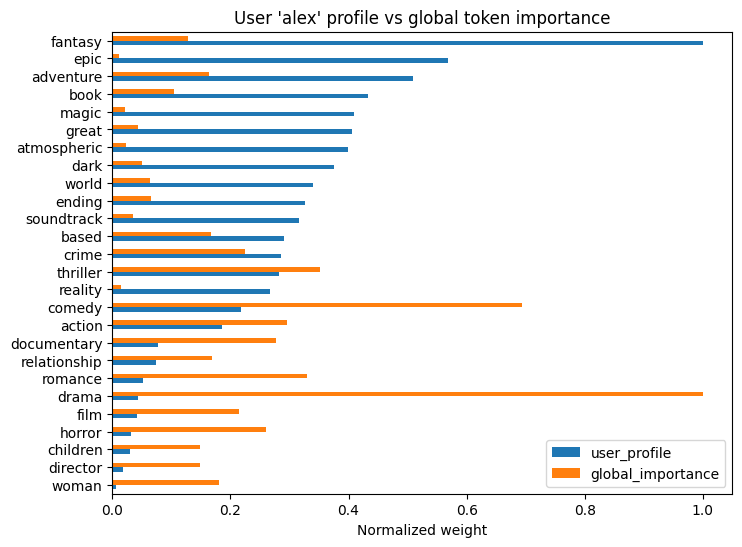

In [20]:
model, movies, X_tfidf, num, tfidf = r4u.load_model_and_features(MODEL_PATH, MOVIE_FEATURES)
profile_name = "alex"
profile_path = ROOT / "user_profiles" / f"{profile_name}.json"

user_ratings = r4u.load_user_ratings(profile_path)
profile = r4u.build_user_profile(movies, X_tfidf, user_ratings)

# tokens in the same order as columns in X_tfidf
vocab_items = sorted(tfidf.vocabulary_.items(), key=lambda x: x[1])
tokens = [tok for tok, _ in vocab_items]

# user profile over tokens
profile_series = pd.Series(profile[:len(tokens)], index=tokens)

# global document frequency for each token
global_df = (X_tfidf > 0).sum(axis=0)
global_df = np.asarray(global_df).ravel()
global_series = pd.Series(global_df, index=tokens)

profile_norm = profile_series / profile_series.max()
global_norm = global_series / global_series.max()

top_user_tokens = profile_norm.sort_values(ascending=False).head(15).index
top_global_tokens = global_norm.sort_values(ascending=False).head(15).index

tokens_union = sorted(set(top_user_tokens) | set(top_global_tokens))

compare_df = pd.DataFrame({
    "user_profile": profile_norm.loc[tokens_union],
    "global_importance": global_norm.loc[tokens_union],
})

compare_df = compare_df.sort_values("user_profile", ascending=True)

ax = compare_df.plot(kind="barh", figsize=(8, 6))
ax.set_xlabel("Normalized weight")
ax.set_title(f"User '{profile_name}' profile vs global token importance")
plt.tight_layout()
plt.show()

In [13]:
find_movie_indices_by_title("Titanic")

,movieId,movie_rowid,title,year
1655,1721,1721,Titanic (1997),1997.0
2067,2157,2157,"Chambermaid on the Titanic, The (Femme de cham...",1998.0
3309,3403,3403,Raise the Titanic (1980),1980.0
3310,3404,3404,Titanic (1953),1953.0
4759,4864,4864,Titanica (1992),1992.0
15700,82602,82602,Titanic Town (1998),1998.0
23714,118916,118916,Titanic (1996),1996.0
33858,143539,143539,Titanic at 100: Mystery Solved (2012),2012.0
46234,170975,170975,The Ten Lives of Titanics the Cat (2007),2007.0
46265,171037,171037,Drain the Titanic (2016),2016.0


In [18]:
movie_to_idx = pd.Series(movies.index.values, index=movies["movie_rowid"])
row_idx = int(movie_to_idx.loc[98809])
row_idx
most_similar_movies_by_row_idx(row_idx, top_k=15)

,movieId,movie_rowid,title,year,n_ratings,mean_rating,similarity
0,118696,118696,The Hobbit: The Battle of the Five Armies (2014),2014.0,8616.0,3.473886,0.648042
1,5952,5952,"Lord of the Rings: The Two Towers, The (2002)",2002.0,67463.0,4.072188,0.630075
2,106489,106489,"Hobbit: The Desolation of Smaug, The (2013)",2013.0,12175.0,3.585667,0.620608
3,4993,4993,"Lord of the Rings: The Fellowship of the Ring,...",2001.0,73122.0,4.092134,0.582746
4,7153,7153,"Lord of the Rings: The Return of the King, The...",2003.0,67449.0,4.094360,0.567734
5,58105,58105,"Spiderwick Chronicles, The (2008)",2008.0,1644.0,3.293187,0.526886
6,65685,65685,Inkheart (2008),2008.0,961.0,3.139438,0.515295
7,2161,2161,"NeverEnding Story, The (1984)",1984.0,12497.0,3.531007,0.481079
8,65359,65359,Earthsea (Legend of Earthsea) (2004),2004.0,108.0,2.685185,0.465437
9,7164,7164,Peter Pan (2003),2003.0,1936.0,3.343492,0.451912


In [19]:
import importlib
from scripts import recommend_for_new_user as r4u

# Reload module to be safe
importlib.reload(r4u)

# Load model & features (model is not actually needed for this experiment, but it's fine)
model, movies, X_tfidf, num, tfidf = r4u.load_model_and_features(MODEL_PATH, MOVIE_FEATURES)

# Quick check of columns (for your sanity)
print("movies.columns:", movies.columns.tolist())

# Load your user ratings (e.g. profile 'alex')
"""
profile_name = "aditi"
profile_path = ROOT / "user_profiles" / f"{profile_name}.json"
user_ratings = r4u.load_user_ratings(profile_path)
print(f"Loaded profile '{profile_name}' with {len(user_ratings)} ratings.")
"""
# Build your user profile vector in TF-IDF space
user_profile_vec = r4u.build_user_profile(movies, X_tfidf, user_ratings)
print("Profile vector shape:", user_profile_vec.shape)


def top_movies_for_profile(
    profile_vec,
    top_k: int = 20,
    min_year: int = 1990,
    min_n_ratings: int = 50,
):
    """Return movies with highest similarity to this user-profile vector."""
    # similarity for all movies (cosine-like, since X_tfidf is L2-normalized)
    sims = (X_tfidf @ profile_vec).ravel()

    # Start with core columns that we actually have
    base_cols = ["movie_rowid", "title"]
    if "year" in movies.columns:
        base_cols.append("year")

    df = movies[base_cols].copy()
    df["sim_to_profile"] = sims

    # Year filter
    if "year" in df.columns and min_year is not None:
        df = df[df["year"] >= min_year]

    # Popularity filter
    if "n_ratings" in movies.columns and min_n_ratings is not None:
        df["n_ratings"] = movies["n_ratings"]
        df = df[df["n_ratings"] >= min_n_ratings]

    # Remove already-rated movies
    rated_ids = set(user_ratings.keys())
    df = df[~df["movie_rowid"].isin(rated_ids)]

    # Sort by similarity
    df = df.sort_values("sim_to_profile", ascending=False).head(top_k)
    return df.reset_index(drop=True)


top_profile_movies = top_movies_for_profile(user_profile_vec, top_k=20)
top_profile_movies

movies.columns: ['movieId', 'title', 'genres', 'tmdb_id', 'movie_rowid', 'n_ratings', 'mean_rating', 'year', 'year_norm']


NameError: name 'user_ratings' is not defined

In [ ]:
# 1) compute profile similarity-only ranking (Experiment 2)
profile_only = top_movies_for_profile(user_profile_vec, top_k=200)
profile_only = profile_only[["movie_rowid", "sim_to_profile", "title"]].copy()
profile_only["rank_profile"] = range(1, len(profile_only) + 1)

# 2) compute model-based recommendations on the same candidate set
recs = r4u.recommend_for_user(
    model=model,
    movies=movies,
    X_tfidf=X_tfidf,
    num=num,
    user_ratings=user_ratings,
    num_recs=200,
    min_year=1990,
    min_n_ratings=50,
)
model_only = recs[["movie_rowid", "pred_rating"]].copy()
model_only["rank_model"] = range(1, len(model_only) + 1)

# 3) join them
joined = profile_only.merge(model_only, on="movie_rowid", how="inner")

# 4) inspect some rows
joined.sort_values("rank_profile").head(20)
joined.sort_values("rank_model").head(20)

Estimated user_mean_rating: 4.025
Built user genre profile.
Predicting ratings for all movies...


,movie_rowid,sim_to_profile,title,rank_profile,pred_rating,rank_model
5,3728,0.265286,One False Move (1992),38,4.430972,5
16,93240,0.204766,Children Who Chase Lost Voices from Deep Below...,144,4.420307,6
4,493,0.270111,Menace II Society (1993),35,4.388544,11
2,6659,0.281627,Tremors (1990),18,4.375799,17
9,176933,0.220570,The Foreigner (2017),97,4.361826,23
8,97988,0.225227,"Bay, The (2012)",87,4.328843,30
1,188,0.303869,"Prophecy, The (1995)",10,4.323106,33
20,136449,0.197309,Ghost in the Shell 2.0 (2008),169,4.319751,38
12,8520,0.209198,Deep Cover (1992),128,4.300945,46
17,2391,0.203526,"Simple Plan, A (1998)",151,4.290125,53
